# Preprocessing of PostNord reviews

Run this code __BEFORE__ *postnord_classification.ipynb*!

## 1. Start-up code: Import packages and get data

In [1]:
# UNCOMMENT TO INSTALL PACKAGES
#!pip install requests pandas numpy matplotlib seaborn

In [2]:
# import packages

# system tools
import os
import requests as req
import re

# data wrangling
import pandas as pd
import numpy as np
import matplotlib as mpl

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define input path
path = os.path.join("..", "in", "postnord_trustpilot_reviews.csv")
# read csv
df = pd.read_csv(path)
# fill empty columns with white space
df.fillna(" ", inplace = True)
# rename columns
df.columns = ['order', 'name', 'date', 'rating', 'text', 'profile_link', 'review_count', 'header']
# save number of rows
with open('../out/development_in_number_of_rows.txt', 'w') as file:
    file.write(f"DEVELOPMENT IN NUMBER OF ROWS DURING CLEANING\n")
    file.write(f"Beginning number of rows: {len(df)}\n")
print(f"Beginning number of rows: {len(df)}")

Beginning number of rows: 399980


## 2. Cleaning and processing

### 2.1 Combine header and text column

In [4]:
# remove three dots symbol (…) from the end of the header
df['header'] = df['header'].str.replace('…', '', regex = False)

In [5]:
# combine the header and text column into a new column

# create a list
review = []

# loop over the dataframe
for index, row in df.iterrows():
    # txt is the text-column
    txt = row["text"]
    # head is the header-column
    head = row["header"]
    # search for the header text in the text-column
    x = re.search(f"^{re.escape(head)}", txt)
    # if the header text occurs in the text-column
    if x:
        # append the text column to the list
        review.append(row['text'])
    # otherwise...
    else:
        # append the header column and the text column to the list with a white space in between
        review.append(row['header'] + " " + row['text'])

# create a new column from the list
df['review'] = review

### 2.2 Make plots: distribution of data and mean review lengths

In [6]:
# TrustPilot color palette for plotting
colors = ['#ff3722','#ff8623','#ffce00','#72cf10','#00b67a']

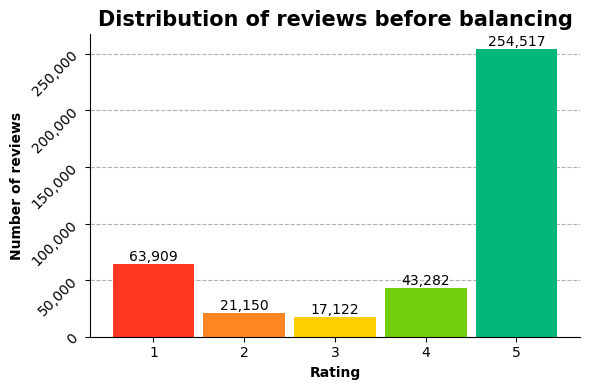

In [7]:
# DISTRIBUTION PLOT

# place gridlines below elements in plots
plt.rc('axes', axisbelow=True)

# plot data distribution
fig, ax = plt.subplots(figsize = (6,4))
ax = df.groupby('rating').review.count().plot.bar(
    ylim=0, color=colors, width= 0.9)
for i, v in enumerate(df.groupby('rating').review.count()): # add bar labels
    ax.text(i, v, f"{v:,.0f}", ha='center', va='bottom')
plt.title("Distribution of reviews before balancing", weight = "bold", fontsize=15)
plt.subplots_adjust(top=0.85) # adjust spacing between the subtitle and title
plt.ylabel('Number of reviews', fontsize = 10, weight = "bold")
plt.xlabel('Rating', fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--') # add a grid
ax.spines[['right', 'top']].set_visible(False) # remove top and right spine
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # show thousands with a comma (1000 -> 1,000)
plt.xticks(rotation='horizontal')
plt.yticks(rotation=45) # rotate y-ticks
plt.tight_layout()  # adjust layout to prevent labels from being cut off
plt.savefig('../out/distribution_of_datapoints_BEFORE_preprosessing.png', dpi=300, bbox_inches='tight') # save the figure
plt.show()

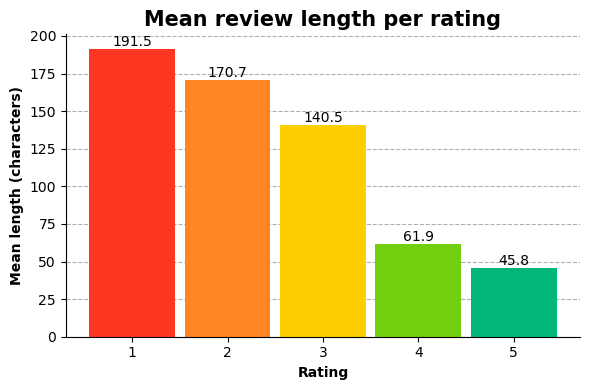

In [8]:
# LENGTH PLOT

# get mean lengths
df["length"] = df.review.str.len() # get length of review
mean_lengths = df.groupby(by = 'rating').mean('length') # get mean lengths per rating
mean_lengths['rating'] = mean_lengths.index # add rating as a column

# get values for plot
height = [l for l in mean_lengths['length']] # y axis
bars = [r for r in mean_lengths['rating']] # x axis
labels = [round(l, 1) for l in mean_lengths['length']] # labels

# plot mean lengths
fig, ax = plt.subplots(figsize = (6,4))
ax.bar(bars, height, align='center', color = colors, width = 0.9)
plt.title("Mean review length per rating", weight = "bold", fontsize=15)
ax.set_xlabel('Rating', fontsize = 10, weight = "bold")
ax.set_ylabel('Mean length (characters)', fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--')
for i in range(len(bars)):
    plt.text(bars[i], height[i], str(labels[i]), ha='center', va='bottom')
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()  # adjust layout to prevent labels from being cut off
plt.savefig('../out/mean_length_pr_category.png', dpi=300, bbox_inches='tight') # save the figure
plt.show()

### 2.3 Drop duplicates

In [9]:
# drop any duplicates
df = df.drop_duplicates(subset=['profile_link', 'date', 'review'], keep='first')
# reset index after removing lines
df = df.reset_index(drop=True)

In [10]:
# save update on number of rows
with open('../out/development_in_number_of_rows.txt', 'a') as file:
    file.write(f"Number of rows after removing duplicates: {len(df)}\n")
print(f"Number of rows after removing duplicates: {len(df)}")

Number of rows after removing duplicates: 399537


### 2.4 Anonymisation and removal of unecessary columns

In [11]:
# drop any columns with 'personfølsom data'
df = df.drop(columns=['name', 'date', 'profile_link', 'header', 'text', 'order', 'review_count', 'length'])

In [12]:
df.head()

,rating,review
0,5,Hurtig levering.
1,5,Altid pakker til tiden
2,5,Som sædvanlig er min pakke leveret på bedste m...
3,5,"Hurtig behandling Alt fungerede, hurtig leveri..."
4,5,"Forbilledligt Pakkepost, når den er bedst!"


### 2.5 General text and data cleaning

In [13]:
clean_review = []

for text in df['review'].tolist():
    # remove punctuation
    text = re.sub('[^\w\s]+', '', text)
    # remove double white spaces
    text = re.sub(' +', ' ', text)
    # remove white space at beginning and end of line
    text = text.strip()
    # make text lower
    text = text.lower()
    # append to list
    clean_review.append(text)

# add clean data to dataframe
df['review'] = clean_review

In [14]:
# add NaN to empty cells
df['review'].replace('', np.nan, inplace=True)
# remove all cells with NaN
df.dropna(subset=['review'], inplace=True)
# reset index after removing lines
df = df.reset_index(drop=True)
# save update on number of rows
with open('../out/development_in_number_of_rows.txt', 'a') as file:
    file.write(f"Number of rows after removing empty rows: {len(df)}\n")
print(f"Number of rows after removing empty rows: {len(df)}")

Number of rows after removing empty rows: 398866


### 2.6 Removal of stopwords

In [15]:
# get Danish stopword list from Github
url = "https://gist.githubusercontent.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b/raw/fa34ef448aff6adbb4b6bab9bda62a8b0f1ee597/stopord.txt"
res = req.get(url)
# create TXT file for stopwords
txt_path = os.path.join("..", "in", "stopwords.txt")
# open empty TXT
file = open(txt_path, "w")
# write stopwords to TXT
file.write(res.text)
# close 'write' mode
file.close()

In [16]:
# read stopwords TXT
with open(txt_path) as file:
    # get lines
    lines = file.readlines()

In [17]:
# create list of stopwords
stopwords = []
for l in lines:
    # remove \n at the end of each line
    stopwords.append(l.strip())

In [18]:
# remove stopwords from data
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [19]:
# remove empty lines (again)
df['review'].replace('', np.nan, inplace=True)
df.dropna(subset=['review'], inplace=True)
# reset index after removing lines
df = df.reset_index(drop=True)
# save update on number of rows
with open('../out/development_in_number_of_rows.txt', 'a') as file:
    file.write(f"Number of rows after removing empty rows (again): {len(df)}\n")
print(f"Number of rows after removing empty rows (again): {len(df)}")

Number of rows after removing empty rows (again): 397199


### 2.7 Remove 1-character reviews

In [20]:
# get length of review (again)
df["length"] = df.review.str.len()

In [21]:
# show texts that will be removed
print(df.loc[np.array(list(map(len,df.review.values)))<2])
# remove texts shorter than 2
df = df.loc[np.array(list(map(len,df.review.values)))>1]
# reset index after removing lines
df = df.reset_index(drop=True)

        rating review  length
13901        4      5       1
16264        5      s       1
25443        5      5       1
28089        4      3       1
40738        5      5       1
52657        3      3       1
64836        5      s       1
79775        1      j       1
79973        5      d       1
94288        5      5       1
116189       4      4       1
137586       5      a       1
173863       5      t       1
224169       1      1       1
231882       5      a       1
234761       5      o       1
242426       5      v       1
263296       5      d       1
284406       1      h       1
296042       1      0       1
298839       4      4       1
320709       3      3       1
322725       5      1       1
331685       5      å       1
364097       4      3       1


In [22]:
# save update on number of rows
with open('../out/development_in_number_of_rows.txt', 'a') as file:
    file.write(f"Number of rows after removing short review: {len(df)}\n")
print(f"Number of rows after removing short reviews: {len(df)}")

Number of rows after removing short reviews: 397174


In [23]:
print(f"Shortest review: {df['length'].min()}")
print(f"Longest review:  {df['length'].max()}")

Shortest review: 2
Longest review:  1724


### 2.8 Balancing the data

In [24]:
# print distribution of data before balancing
df['rating'].value_counts()

5    252395
1     63709
4     42912
2     21100
3     17058
Name: rating, dtype: int64

In [25]:
# balancing function
def balance(dataframe, random_state = 42): # takes a dataframe and a random state as input (default = 42)
    # take a random sample from each label
    out = (dataframe.groupby('rating', as_index=False)
            .apply(lambda x: x.sample(dataframe['rating'].value_counts().min(), random_state = random_state))
            .reset_index(drop=True))
    return out

In [26]:
# balance the data
df = balance(df)

In [27]:
# make sure the ratings are parsed as strings not integers!
df['rating'] = df['rating'].astype(str)
# reset index after balancing the data
df = df.reset_index(drop=True)

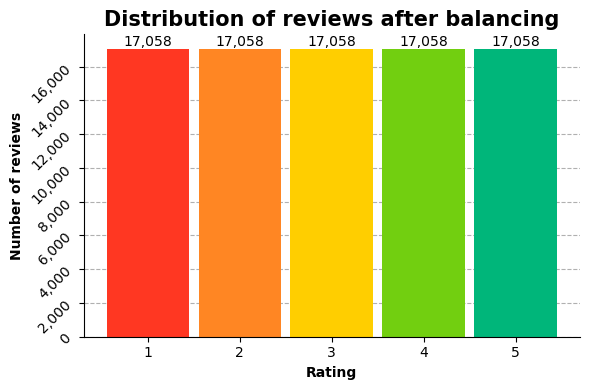

In [28]:
# plot the new distribution of data
fig, ax = plt.subplots(figsize=(6,4))
ax = df.groupby('rating').review.count().plot.bar(
    ylim=0, color=colors, width= 0.9)
for i, v in enumerate(df.groupby('rating').review.count()): # add bar labels
    ax.text(i, v, f"{v:,.0f}", ha='center', va='bottom')
plt.title("Distribution of reviews after balancing", weight = "bold", fontsize=15)
plt.subplots_adjust(top=0.85) # adjust spacing between the subtitle and title
plt.ylabel('Number of reviews', fontsize = 10, weight = "bold")
plt.xlabel('Rating', fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--') # add a grid
ax.spines[['right', 'top']].set_visible(False) # remove top and right spine
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # show thousands with a comma (1000 -> 1,000)
plt.xticks(rotation='horizontal')
plt.yticks(rotation=45)
plt.tight_layout()  # adjust layout to prevent labels from being cut off
plt.savefig('../out/distribution_of_datapoints_AFTER_preprosessing.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Save the cleaned and balanced dataset

In [29]:
# create a path for saving the cleaned dataframe
balancepath = os.path.join("..", "in", "balanced_dataset.csv")
# save the CSV
df.to_csv(balancepath, index = False)